# Evaluation of Encoding Sizes

An examination of encoding sizes of `NNTP` data using different encoding schemes.

In [1]:
import io
import json
import matplotlib.pyplot as plt
import os
import subprocess
from threading import Thread
import zlib

import cbor2
from faker import Faker
import numpy as np
import pandas as pd
import requests as rq
import seaborn as sns

from py_dtn7 import DTNWSClient

cm = 1/2.54
linewidth = 14.6979 * cm # line width in TuDa template
sns.set_theme(context='paper', style='whitegrid', palette='deep', rc={'figure.figsize':(linewidth, 6*cm)})

Define all required data for article transfer:

In [2]:
node_id = "n1"

email_id = "anna"
email_domain = "monntpy.org"
email_address = f"{email_id}@{email_domain}"

group_name = "monntpy.eval"

subject = "Corrupti commodi consequuntur fugiat corporis atque eaque"
message_id = references = f"<714491769820-0@{node_id}-mail-{email_domain}-{email_id}.dtn>"


# body = "".join(articles[article_length])

dtn_sender = f"dtn://{node_id}/mail/{email_domain}/{email_id}"
dtn_receiver = f"dtn://{group_name}/~news"
dtn_lifetime = 5

url = "http://localhost:3000"

fake = Faker("de_DE")
Faker.seed(42)

**PLEASE READ**: in the following, you can either let Python start the dtnd in the background by executing the next cell or manually start the dtnd with the command that is printed in the second cell down.

If you start the process, be nice to your system and remember to kill it after collecting the needed data.

In [3]:
dtnd = subprocess.Popen(["dtnd", "--nodeid", node_id, "--cla", "mtcp", "--endpoint", dtn_receiver, "--endpoint", dtn_sender], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [4]:
print(f"dtnd --nodeid {node_id} --cla mtcp --endpoint {dtn_receiver} --endpoint {dtn_sender}")

dtnd --nodeid n1 --cla mtcp --endpoint dtn://monntpy.eval/~news --endpoint dtn://n1/mail/monntpy.org/anna


Define callback and a buffer to store all messages that are returned from the WS client

In [5]:
ws_msg_buffer = []
def on_msg(ws_data):
    ws_msg_buffer.append(ws_data)

c = DTNWSClient(callback=on_msg)
Thread(target=c.start_client, daemon=True).start()

In [6]:
def get_latest_bundle():
    bid_list_resp = rq.get(f"{url}/status/bundles")
    bid_list = sorted(json.loads(bid_list_resp.content))
    return rq.get(f"{url}/download?{bid_list[-1]}").content

In [7]:
stats = []
num_runs = 50

for num_paragraphs in range (1,21):
    for f in range(num_runs):

        body = '\n\n'.join([fake.paragraph(nb_sentences=15, variable_nb_sentences=True) for _ in range(num_paragraphs)])
        len_body = len(body)
        
        dtn_args: dict = {
            # map NNTP to BP7 MAPPING
            "source": dtn_sender,
            "destination": dtn_receiver,
            "delivery_notification": False,
            "lifetime": dtn_lifetime,
        }
        dtn_payload: dict = {
            "subject": subject,
            "body": body,
            "references": references,
        }


        nntp_payload = f"""From - Fri, 07 Oct 2022 13:03:43 GMT
X-Mozilla-Status: 0001
X-Mozilla-Status2: 00800000
Date: Fri, 7 Oct 2022 13:03:43 +0000
MIME-Version: 1.0
User-Agent: Mozilla/5.0 (X11; Linux x86_64; rv:102.0) Gecko/20100101  Thunderbird/102.2.2
Newsgroups: {group_name}
References: {references}
Message-ID: {message_id}
Content-Language: en-US
From: "Firstname Lastname" <{email_address}>
Subject: {subject}
Content-Type: text/plain; charset=UTF-8; format=flowed
Content-Transfer-Encoding: 7bit

{body}
."""
        
        # size_nntp.append(len(nntp_payload))
        stats.append({"type": "NNTP", "size": len(nntp_payload.encode()), "num_par": num_paragraphs, "len_body": len_body})
        
        # send payload uncompressed
        c.send_data(**dtn_args, data=cbor2.dumps(dtn_payload))
        stats.append({"type": "BP7_text", "size": len(get_latest_bundle()), "num_par": num_paragraphs, "len_body": len_body})
        
        # send payload zlib compressed
        dtn_payload["body"] = zlib.compress(body.encode("utf-8"))
        c.send_data(**dtn_args, data=cbor2.dumps(dtn_payload))
        stats.append({"type": "BP7_zlib", "size": len(get_latest_bundle()) / 10, "num_par": num_paragraphs, "len_body": len_body})


df = pd.DataFrame(stats)

Kill the dtnd in case it was started above:

In [14]:
dtnd.kill()

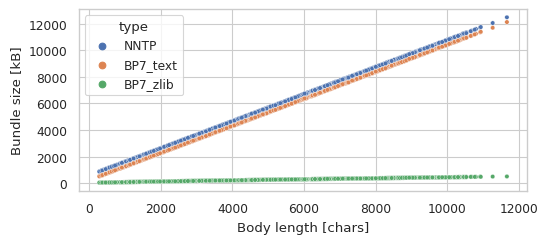

In [20]:
g_all = sns.scatterplot(data=df, x="len_body", y="size", hue="type", s=10)
_ = g_all.set(xlabel='Body length [chars]', ylabel='Bundle size [kB]')
plt.savefig('ch6_encoding_all.pdf', bbox_inches="tight")

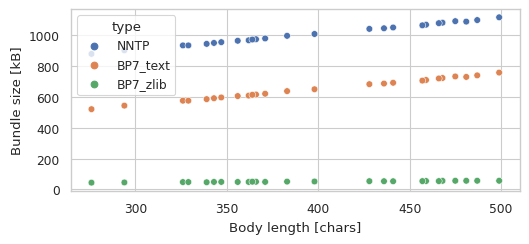

In [21]:
g_small = sns.scatterplot(data=df[df["len_body"] < 500], x="len_body", y="size", hue="type")
_ = g_small.set(xlabel='Body length [chars]', ylabel='Bundle size [kB]')
plt.savefig("ch6_encoding_small.pdf", bbox_inches="tight")